### 1) Import libraries


In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
sns.set_style('white')

In [6]:
import re 
import nltk 
import spacy
import string
import itertools
import contractions
from bs4 import BeautifulSoup
nltk.download('stopwords')
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import statsmodels.api as sm

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD



from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amr_a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2) Data Loading

In [14]:
# Read the dataset from csv file
df = pd.read_csv("../Data/spam.csv", encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
df.shape

(5572, 5)

In [18]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [19]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [20]:
df.rename(columns={'v1': 'class', 'v2': 'Message'}, inplace=True)
df.head()

,class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
for row in df.head(10).iterrows():
    print(row[1]['Message'] +', '+  row[1]['class']) 

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..., ham
Ok lar... Joking wif u oni..., ham
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's, spam
U dun say so early hor... U c already then say..., ham
Nah I don't think he goes to usf, he lives around here though, ham
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv, spam
Even my brother is not like to speak with me. They treat me like aids patent., ham
As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune, ham
WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only., 

### 3) EDA

In [33]:
# Find all category
classes = list(df['class'].unique())
classes

['ham', 'spam']

In [34]:
clas = df.groupby('class')
print("Train Total Categories:", clas.ngroups)
print(clas.size())

Train Total Categories: 2
class
ham     4825
spam     747
dtype: int64


In [35]:
# Check null values
df.isnull().sum()

class      0
Message    0
dtype: int64

In [36]:
df.duplicated().sum()

414

In [37]:
df.drop_duplicates(inplace=True)

### 4. Visualizationm

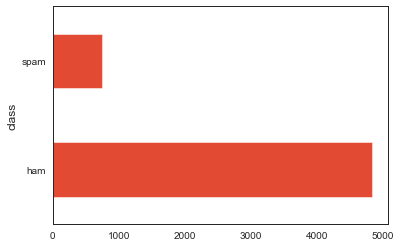

In [41]:
clas.size().plot(kind='barh')
plt.show();

<AxesSubplot:ylabel='class'>

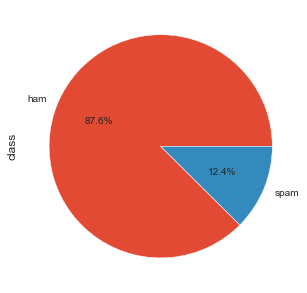

In [42]:
labels = classes

fig, ax = plt.subplots(1, 1, figsize=(5,10))
df['class'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

### 5. Text Preprocessing

Normally texts have:
<ol>
<li>too many spelling mistakes in the text</li>
<li>too many numbers and punctuations</li>
<li>too many emojis and emoticons and username and links too. </li>
<li>Some of the text parts are not in the English language. Data is having a mixture of more than one language</li>
<li>Some of the words are combined with the hyphen or data having contractions word or Repetitions of words.</li>

</ol>

<p>Here i will clean the text by doing the following steps:
<ol>

<li>Ensure category name consistency</li>
<li>Lowecasing the data</li>
<li>Removing Puncuatations</li>
<li>Removing Numbers</li>
<li>Removing extra space</li>
<li>Removing Contractions</li>
<li>Removing HTML tags</li>
<li>Removing & Finding URL and Email id</li>
<li>Removing Stop Words</li>
<li>Standardizing and Spell Check</li>
</ol>


In [44]:
# 1) Ensure category name consistency

df1 = df.loc[(df['class'] != 'spam') & 
            (df['class'] != 'ham')]

df1.head()

,class,Message


In [45]:
# 2) Normalizing Text (lower) 

def normalize(content):
    content = content.lower()
    return content

# 3) Removing Puncuatations

def remove_punct(content):
    content = content.translate(content.maketrans("", "", string.punctuation))
    return content

#  4) cleaning digits

def remove_num(content):
    content = ''.join([i for i in content if not i.isdigit()])

    return content

# 5) Remove extra-space

def remove_spaces(content):
    content = " ".join(content.split())

    return content

# 6)# Remove Contraction

def remove_cont(content):
    content = contractions.fix(content)
    
    return content

# 7) Remove Html Tags

def remove_html(content):
    # parse html content
    soup = BeautifulSoup(content, "html.parser")

    for data in soup(['style', 'script', 'code', 'a']):
        # Remove tags
        data.decompose()
    # return data by retrieving the tag content
    content = ' '.join(soup.stripped_strings)
    
    return content

# 8) Remove URLs and E-mails (UniCode)

def remove_unicode(content):
    content = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", content)
    return content

# 9) Removing Stop Words

def remove_stopword(content):
    STOPWORDS = set(stopwords.words('english'))
    content = " ".join([word for word in str(content).split() if word not in STOPWORDS])
    return content

# 10) Standardizing and Spell Check

def Standardize(content):
    content = ''.join(''.join(s)[:2] for _, s in itertools.groupby(content))
    spell = Speller(lang='en')
    content = spell(content)
    return content

# 11) Remove some Extra-words

def remove_extrawords(content):
    stop=['href','lt','gt','ii','iii','ie','quot','com']  ## This all words are most repeated words it does not make any sense
    content = content.split(" ")
    filtered_list=[]
    for i in content:
        if i not in stop:
            filtered_list.append(i)
            
    content = ' '.join(filtered_list)
    return content

In [46]:
def clean_text(content):
    
    # Normalize
    
    Normalized_content = normalize(content)
    
    # Removing Puncuatations
    
    clean_content = remove_punct(Normalized_content)

    # cleaning digits

    clean_content = remove_num(clean_content)

    # Remove extra-space
    
    clean_content = remove_spaces(clean_content)
    
    # Remove Contraction

    clean_content = remove_cont(clean_content)
    
    # Remove Html Tags

    clean_content = remove_html(clean_content)
    
    # Remove URLs and E-mails (UniCode)

    clean_content = remove_unicode(clean_content)
    
    # Removing Stop Words

    clean_content = remove_stopword(clean_content)

    # Remove some Extra-words
    
    clean_content = remove_extrawords(clean_content)

    return clean_content

In [48]:
df['Message'] = df['Message'].apply(clean_text)

### 6 ) Saving datasets obtained from preprocessing.

In [50]:
df.to_csv(r'../Data/cleaned_spam.csv')